In [1]:
!pip install pennylane

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 57.1/57.1 kB 2.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.8/4.8 MB 56.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 930.8/930.8 kB 42.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.6/2.6 MB 71.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 75.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 51.5/51.5 kB 3.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 167.9/167.9 kB 12.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.6/8.6 MB 134.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 72.5/72.5 kB 4.8 MB/s eta 0:00:00


In [2]:
import os
import numpy as np
import torch
import torch.nn as nn
import pennylane as qml
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
from PIL import Image
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, TensorDataset
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
# 2. DATA LOADING AND PREPROCESSING
def load_leaf_dataset(base_path, classes, img_size=(128, 128)):
    """
    Loads and preprocesses the Indian Bay leaf dataset from a directory.
    """
    images = []
    labels = []

    # Define image transformations
    transform = transforms.Compose([
        transforms.Resize(img_size),
        transforms.ToTensor(),
        transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)) # Normalize for 3-channel images
    ])

    for label_idx, class_name in enumerate(classes):
        class_path = os.path.join(base_path, class_name)
        for img_name in os.listdir(class_path):
            img_path = os.path.join(class_path, img_name)
            try:
                image = Image.open(img_path).convert("RGB")
                image_tensor = transform(image)
                images.append(image_tensor)
                labels.append(label_idx)
            except Exception as e:
                print(f"Could not load image {img_path}: {e}")

    return torch.stack(images), torch.tensor(labels)

In [4]:
base_path = "/content/drive/MyDrive/Indian_Bay_leaf_or_Tejpatta_Dataset_Balanced"
classes = ["Disease", "Dry_Leaf", "Healthy"]

In [5]:
print("Loading and preprocessing data from Google Drive...")
images, labels = load_leaf_dataset(base_path, classes)
print(f"Loaded {len(images)} images.")

# Count and print the number of images per class
class_counts = torch.bincount(labels)
print("\nTotal images per class:")
for i, count in enumerate(class_counts):
    print(f"{classes[i]}: {count.item()}")

Loading and preprocessing data from Google Drive...
Loaded 3444 images.

Total images per class:
Disease: 1148
Dry_Leaf: 1148
Healthy: 1148


In [6]:
# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(
    images, labels, test_size=0.2, random_state=42, stratify=labels
)

# Create DataLoader for batching
train_dataset = TensorDataset(X_train, y_train)
test_dataset = TensorDataset(X_test, y_test)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

In [7]:
# 3. QUANTUM CIRCUIT AND HYBRID MODEL DEFINITION

n_qubits = 4
dev = qml.device("default.qubit", wires=n_qubits)

@qml.qnode(dev, interface="torch")
def quantum_circuit(inputs, weights):
    qml.AngleEmbedding(inputs, wires=range(n_qubits))
    for i in range(n_qubits):
        qml.RY(weights[i], wires=i)
    qml.CNOT(wires=[0, 1])
    qml.CNOT(wires=[2, 3])
    qml.CNOT(wires=[1, 2])
    return [qml.expval(qml.PauliZ(i)) for i in range(n_qubits)]

class HybridCNNQNN(nn.Module):
    def __init__(self):
        super(HybridCNNQNN, self).__init__()

        # --- Classical Feature Extractor ---
        self.conv1 = nn.Conv2d(3, 8, kernel_size=3, stride=2, padding=1)
        self.pool1 = nn.MaxPool2d(2)
        self.conv2 = nn.Conv2d(8, 16, kernel_size=3, stride=2, padding=1)
        self.pool2 = nn.MaxPool2d(2)
        self.relu = nn.ReLU()

        # Calculate the output size of the convolutional layers dynamically
        # Create a dummy tensor to pass through the conv and pooling layers
        dummy_input = torch.randn(1, 3, 128, 128) # Use the actual input image size
        x = self.pool1(self.relu(self.conv1(dummy_input)))
        x = self.pool2(self.relu(self.conv2(x)))
        flattened_size = x.view(x.size(0), -1).size(1)

        # --- Classical-to-Quantum Link ---
        self.fc_link = nn.Linear(flattened_size, 4)

        # --- Quantum Layer ---
        weight_shapes = {"weights": n_qubits}
        self.quantum_layer = qml.qnn.TorchLayer(quantum_circuit, weight_shapes)

        # --- Classical Classifier Head ---
        self.fc_out = nn.Linear(4, 3) # Output for 3 classes

    def forward(self, x):
        x = self.pool1(self.relu(self.conv1(x)))
        x = self.pool2(self.relu(self.conv2(x)))
        x = x.view(x.size(0), -1)
        x = self.fc_link(x)
        x = self.quantum_layer(x)
        return self.fc_out(x)

print(f"Using {n_qubits} qubits.")
print("Hybrid model defined for the leaf dataset.")

Using 4 qubits.
Hybrid model defined for the leaf dataset.


In [8]:
model = HybridCNNQNN()
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
loss_fn = nn.CrossEntropyLoss()

print(f"Using {type(optimizer).__name__} optimizer with {optimizer.param_groups[0]['lr']} learning rate")
print("Training setup complete.")

Using Adam optimizer with 0.01 learning rate
Training setup complete.


In [ ]:
# 5. TRAINING LOOP

import time

EPOCHS = 100
loss_history = []
acc_history = []

print("Starting training...")
start = time.time()
for epoch in range(EPOCHS):
    model.train()
    running_loss = 0.0
    correct_preds = 0
    total_preds = 0

    for batch_X, batch_y in train_loader:
        optimizer.zero_grad()
        y_pred = model(batch_X)
        loss = loss_fn(y_pred, batch_y)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        y_pred_class = torch.argmax(y_pred, dim=1)
        correct_preds += (y_pred_class == batch_y).sum().item()
        total_preds += batch_y.size(0)

    epoch_loss = running_loss / len(train_loader)
    epoch_acc = correct_preds / total_preds
    loss_history.append(epoch_loss)
    acc_history.append(epoch_acc)

    print(f"Epoch {epoch+1}/{EPOCHS} -> Loss: {epoch_loss:.4f}, Accuracy: {epoch_acc*100:.2f}%")

end = time.time()
print(f"Training time: {end - start} seconds")
print("Training finished.")

Starting training...
Epoch 1/100 -> Loss: 0.7136, Accuracy: 60.58%
Epoch 2/100 -> Loss: 0.4073, Accuracy: 82.21%
Epoch 3/100 -> Loss: 0.2369, Accuracy: 91.03%
Epoch 4/100 -> Loss: 0.1645, Accuracy: 93.76%
Epoch 5/100 -> Loss: 0.1206, Accuracy: 95.97%
Epoch 6/100 -> Loss: 0.2001, Accuracy: 92.56%
Epoch 7/100 -> Loss: 0.1483, Accuracy: 94.19%
Epoch 8/100 -> Loss: 0.0850, Accuracy: 97.31%
Epoch 9/100 -> Loss: 0.0526, Accuracy: 98.33%
Epoch 10/100 -> Loss: 0.0528, Accuracy: 98.29%
Epoch 11/100 -> Loss: 0.0312, Accuracy: 99.42%
Epoch 12/100 -> Loss: 0.0366, Accuracy: 98.84%
Epoch 13/100 -> Loss: 0.0211, Accuracy: 99.64%
Epoch 14/100 -> Loss: 0.0725, Accuracy: 97.02%
Epoch 15/100 -> Loss: 0.0495, Accuracy: 98.19%
Epoch 16/100 -> Loss: 0.0214, Accuracy: 99.42%
Epoch 17/100 -> Loss: 0.0314, Accuracy: 99.02%
Epoch 18/100 -> Loss: 0.0194, Accuracy: 99.49%
Epoch 19/100 -> Loss: 0.0242, Accuracy: 99.17%
Epoch 20/100 -> Loss: 0.0565, Accuracy: 97.86%
Epoch 21/100 -> Loss: 0.0744, Accuracy: 97.60%
E

In [ ]:
# 6. EVALUATION AND VISUALIZATION

print("Evaluating on test data...")
model.eval()
all_preds = []
all_true = []
with torch.no_grad():
    for batch_X, batch_y in test_loader:
        y_test_pred = model(batch_X)
        predicted_classes = torch.argmax(y_test_pred, dim=1)
        all_preds.extend(predicted_classes.numpy())
        all_true.extend(batch_y.numpy())

Evaluating on test data...



Classification Report:

              precision    recall  f1-score   support

     Disease       0.96      0.98      0.97       229
    Dry_Leaf       1.00      1.00      1.00       230
     Healthy       0.98      0.96      0.97       230

    accuracy                           0.98       689
   macro avg       0.98      0.98      0.98       689
weighted avg       0.98      0.98      0.98       689



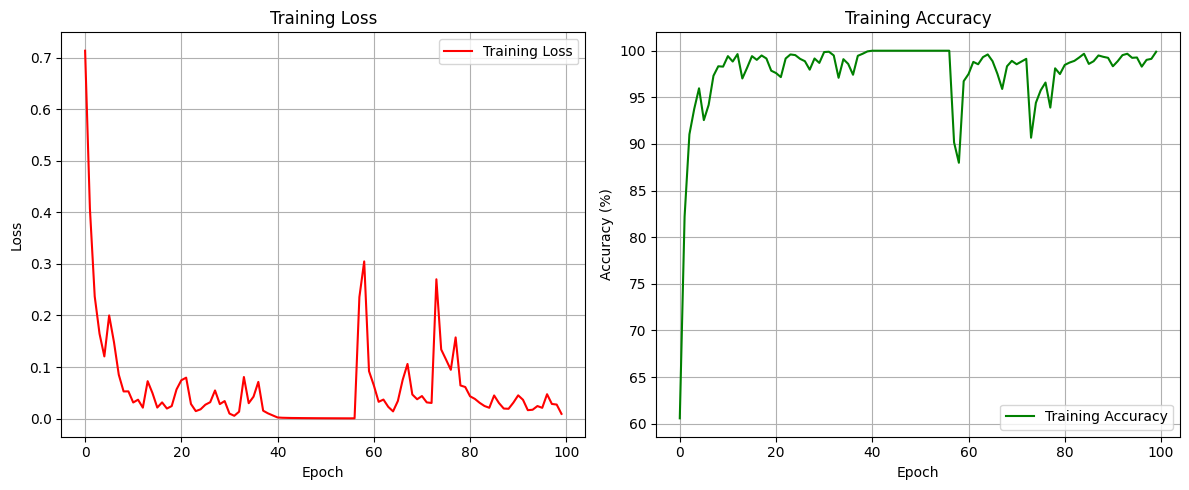

In [ ]:
print("\nClassification Report:\n")
print(classification_report(all_true, all_preds, target_names=classes))

# --- Plotting Training History ---
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(loss_history, label='Training Loss', color='red')
plt.title('Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.grid(True)
plt.legend()

plt.subplot(1, 2, 2)
plt.plot([a * 100 for a in acc_history], label='Training Accuracy', color='green')
plt.title('Training Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.grid(True)
plt.legend()

plt.tight_layout()
plt.show()

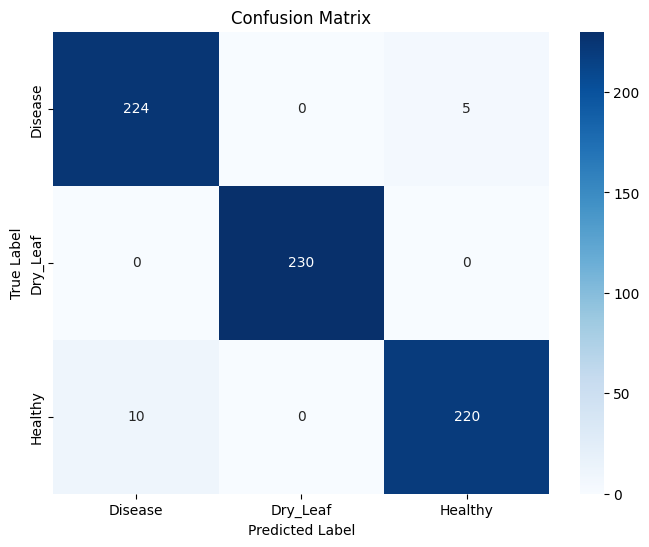

In [ ]:
# --- Plotting Confusion Matrix ---
cm = confusion_matrix(all_true, all_preds)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=classes, yticklabels=classes)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

# Traning the model on validation dataset to check for overfitting and underfitting

In [ ]:
# 5. TRAINING LOOP

import time

EPOCHS = 100
loss_history = []
acc_history = []
val_loss_history = [] # Initialize list for validation loss
val_acc_history = [] # Initialize list for validation accuracy

print("Starting training...")
start = time.time()
for epoch in range(EPOCHS):
    model.train()
    running_loss = 0.0
    correct_preds = 0
    total_preds = 0

    for batch_X, batch_y in train_loader:
        optimizer.zero_grad()
        y_pred = model(batch_X)
        loss = loss_fn(y_pred, batch_y)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        y_pred_class = torch.argmax(y_pred, dim=1)
        correct_preds += (y_pred_class == batch_y).sum().item()
        total_preds += batch_y.size(0)

    epoch_loss = running_loss / len(train_loader)
    epoch_acc = correct_preds / total_preds
    loss_history.append(epoch_loss)
    acc_history.append(epoch_acc)

    # --- Validation Phase ---
    model.eval() # Set model to evaluation mode
    running_val_loss = 0.0
    correct_val_preds = 0
    total_val_preds = 0

    with torch.no_grad(): # Disable gradient calculation
        for batch_X_val, batch_y_val in val_loader:
            y_val_pred = model(batch_X_val)
            val_loss = loss_fn(y_val_pred, batch_y_val)

            running_val_loss += val_loss.item()
            y_val_pred_class = torch.argmax(y_val_pred, dim=1)
            correct_val_preds += (y_val_pred_class == batch_y_val).sum().item()
            total_val_preds += batch_y_val.size(0)

    epoch_val_loss = running_val_loss / len(val_loader)
    epoch_val_acc = correct_val_preds / total_val_preds
    val_loss_history.append(epoch_val_loss)
    val_acc_history.append(epoch_val_acc)

    print(f"Epoch {epoch+1}/{EPOCHS} -> Train Loss: {epoch_loss:.4f}, Train Acc: {epoch_acc*100:.2f}%, Val Loss: {epoch_val_loss:.4f}, Val Acc: {epoch_val_acc*100:.2f}%")

    model.train() # Set model back to training mode

end = time.time()
print(f"Training time: {end - start} seconds")
print("Training finished.")

Starting training...
Epoch 1/100 -> Train Loss: 0.7906, Train Acc: 60.84%, Val Loss: 0.5516, Val Acc: 66.62%
Epoch 2/100 -> Train Loss: 0.5128, Train Acc: 67.04%, Val Loss: 0.4933, Val Acc: 66.62%
Epoch 3/100 -> Train Loss: 0.4853, Train Acc: 66.31%, Val Loss: 0.4803, Val Acc: 66.62%
Epoch 4/100 -> Train Loss: 0.4655, Train Acc: 73.18%, Val Loss: 0.4198, Val Acc: 83.31%
Epoch 5/100 -> Train Loss: 0.4026, Train Acc: 80.25%, Val Loss: 0.3227, Val Acc: 86.94%
Epoch 6/100 -> Train Loss: 0.3179, Train Acc: 86.11%, Val Loss: 0.3099, Val Acc: 85.20%
Epoch 7/100 -> Train Loss: 0.2457, Train Acc: 89.69%, Val Loss: 0.1808, Val Acc: 92.89%
Epoch 8/100 -> Train Loss: 0.1765, Train Acc: 93.08%, Val Loss: 0.1390, Val Acc: 95.36%
Epoch 9/100 -> Train Loss: 0.1347, Train Acc: 94.77%, Val Loss: 0.1069, Val Acc: 96.81%
Epoch 10/100 -> Train Loss: 0.1147, Train Acc: 96.03%, Val Loss: 0.0921, Val Acc: 96.95%
Epoch 11/100 -> Train Loss: 0.0802, Train Acc: 97.53%, Val Loss: 0.0720, Val Acc: 98.11%
Epoch 12/

Evaluating on test data...

Classification Report:

              precision    recall  f1-score   support

     Disease       0.99      0.98      0.98       230
    Dry_Leaf       1.00      0.99      1.00       229
     Healthy       0.98      1.00      0.99       230

    accuracy                           0.99       689
   macro avg       0.99      0.99      0.99       689
weighted avg       0.99      0.99      0.99       689



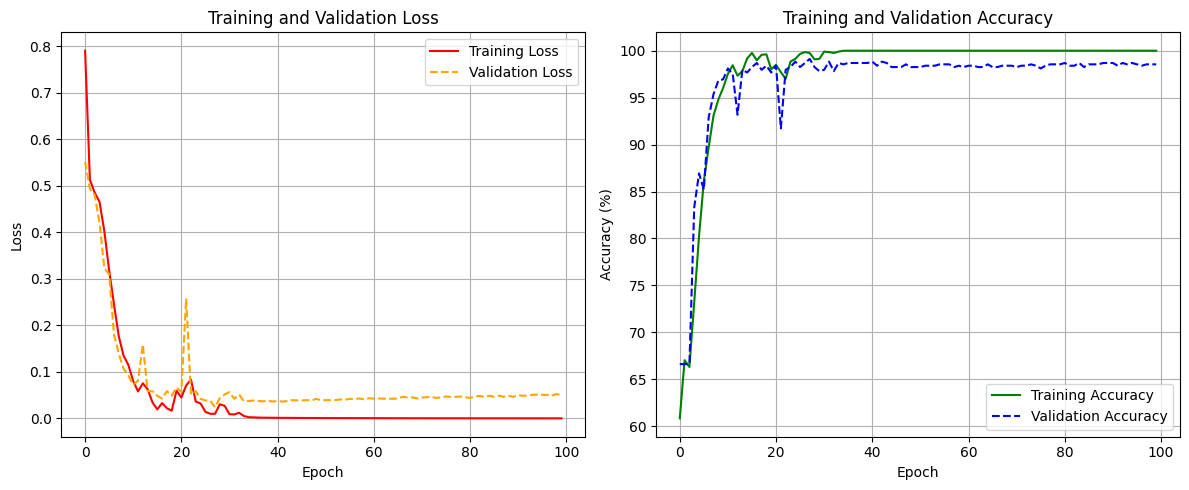

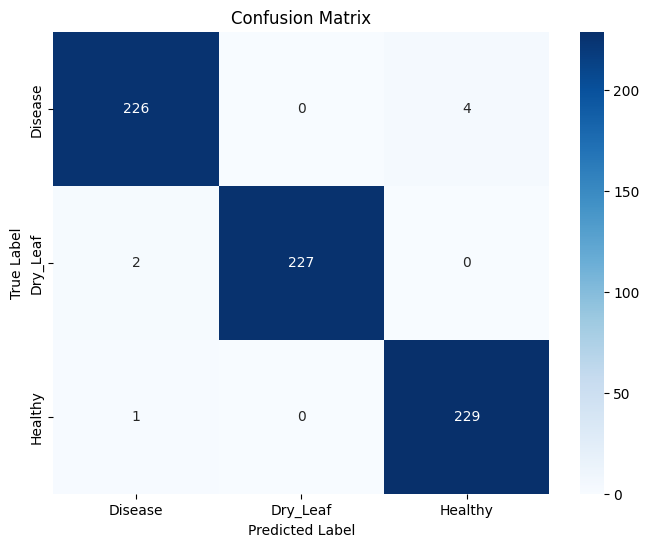

In [ ]:
# 6. EVALUATION AND VISUALIZATION

print("Evaluating on test data...")
model.eval()
all_preds = []
all_true = []
with torch.no_grad():
    for batch_X, batch_y in test_loader:
        y_test_pred = model(batch_X)
        predicted_classes = torch.argmax(y_test_pred, dim=1)
        all_preds.extend(predicted_classes.numpy())
        all_true.extend(batch_y.numpy())

print("\nClassification Report:\n")
print(classification_report(all_true, all_preds, target_names=classes))

# --- Plotting Training and Validation History ---
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(loss_history, label='Training Loss', color='red')
plt.plot(val_loss_history, label='Validation Loss', color='orange', linestyle='--') # Plot validation loss
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.grid(True)
plt.legend()

plt.subplot(1, 2, 2)
plt.plot([a * 100 for a in acc_history], label='Training Accuracy', color='green')
plt.plot([a * 100 for a in val_acc_history], label='Validation Accuracy', color='blue', linestyle='--') # Plot validation accuracy
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.grid(True)
plt.legend()

plt.tight_layout()
plt.show()

# --- Plotting Confusion Matrix ---
cm = confusion_matrix(all_true, all_preds)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=classes, yticklabels=classes)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

# Trying more number of qubits

In [23]:
# Re-initialize the model with the new number of qubits
n_qubits = 8
dev = qml.device("default.qubit", wires=n_qubits)

@qml.qnode(dev, interface="torch")
def quantum_circuit(inputs, weights):
    qml.AngleEmbedding(inputs, wires=range(n_qubits))
    for i in range(n_qubits):
        qml.RY(weights[i], wires=i)
    qml.CNOT(wires=[0, 1])
    qml.CNOT(wires=[2, 3])
    qml.CNOT(wires=[1, 2])
    return [qml.expval(qml.PauliZ(i)) for i in range(n_qubits)]

class HybridCNNQNN(nn.Module):
    def __init__(self):
        super(HybridCNNQNN, self).__init__()

        # --- Classical Feature Extractor ---
        self.conv1 = nn.Conv2d(3, 8, kernel_size=3, stride=2, padding=1)
        self.pool1 = nn.MaxPool2d(2)
        self.conv2 = nn.Conv2d(8, 16, kernel_size=3, stride=2, padding=1)
        self.pool2 = nn.MaxPool2d(2)
        self.relu = nn.ReLU()

        # Calculate the output size of the convolutional layers dynamically
        # Create a dummy tensor to pass through the conv and pooling layers
        dummy_input = torch.randn(1, 3, 128, 128) # Use the actual input image size
        x = self.pool1(self.relu(self.conv1(dummy_input)))
        x = self.pool2(self.relu(self.conv2(x)))
        flattened_size = x.view(x.size(0), -1).size(1)

        # --- Classical-to-Quantum Link ---
        # The output size of this layer must match the number of qubits
        self.fc_link = nn.Linear(flattened_size, n_qubits)

        # --- Quantum Layer ---
        weight_shapes = {"weights": n_qubits}
        self.quantum_layer = qml.qnn.TorchLayer(quantum_circuit, weight_shapes)

        # --- Classical Classifier Head ---
        # The input size of this layer must match the output size of the quantum layer (n_qubits)
        self.fc_out = nn.Linear(n_qubits, 3) # Output for 3 classes

    def forward(self, x):
        x = self.pool1(self.relu(self.conv1(x)))
        x = self.pool2(self.relu(self.conv2(x)))
        x = x.view(x.size(0), -1)
        x = self.fc_link(x)
        x = self.quantum_layer(x)
        return self.fc_out(x)

model = HybridCNNQNN()
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
loss_fn = nn.CrossEntropyLoss()

print(f"Using {n_qubits} qubits in the re-initialized model.")
print("Model re-initialized for the new number of qubits.")

Using 8 qubits in the re-initialized model.
Model re-initialized for the new number of qubits.


In [24]:
import time
print(f"Using {n_qubits} qubits.")

EPOCHS = 100
loss_history = []
acc_history = []

print("Starting training...")
start = time.time()
for epoch in range(EPOCHS):
    model.train()
    running_loss = 0.0
    correct_preds = 0
    total_preds = 0

    for batch_X, batch_y in train_loader:
        optimizer.zero_grad()
        y_pred = model(batch_X)
        loss = loss_fn(y_pred, batch_y)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        y_pred_class = torch.argmax(y_pred, dim=1)
        correct_preds += (y_pred_class == batch_y).sum().item()
        total_preds += batch_y.size(0)

    epoch_loss = running_loss / len(train_loader)
    epoch_acc = correct_preds / total_preds
    loss_history.append(epoch_loss)
    acc_history.append(epoch_acc)

    print(f"Epoch {epoch+1}/{EPOCHS} -> Loss: {epoch_loss:.4f}, Accuracy: {epoch_acc*100:.2f}%")

end = time.time()
print(f"Training time: {end - start} seconds")
print("Training finished.")

Using 8 qubits.
Starting training...
Epoch 1/100 -> Loss: 0.5388, Accuracy: 76.88%
Epoch 2/100 -> Loss: 0.2377, Accuracy: 90.74%
Epoch 3/100 -> Loss: 0.1536, Accuracy: 94.30%
Epoch 4/100 -> Loss: 0.1435, Accuracy: 94.66%
Epoch 5/100 -> Loss: 0.2329, Accuracy: 91.29%
Epoch 6/100 -> Loss: 0.0645, Accuracy: 98.15%
Epoch 7/100 -> Loss: 0.0329, Accuracy: 99.35%
Epoch 8/100 -> Loss: 0.0235, Accuracy: 99.53%
Epoch 9/100 -> Loss: 0.0968, Accuracy: 96.37%
Epoch 10/100 -> Loss: 0.0744, Accuracy: 97.28%
Epoch 11/100 -> Loss: 0.0172, Accuracy: 99.60%
Epoch 12/100 -> Loss: 0.0147, Accuracy: 99.67%
Epoch 13/100 -> Loss: 0.0037, Accuracy: 100.00%
Epoch 14/100 -> Loss: 0.0029, Accuracy: 100.00%
Epoch 15/100 -> Loss: 0.0689, Accuracy: 97.13%
Epoch 16/100 -> Loss: 0.0512, Accuracy: 98.22%
Epoch 17/100 -> Loss: 0.0547, Accuracy: 98.15%
Epoch 18/100 -> Loss: 0.0214, Accuracy: 99.27%
Epoch 19/100 -> Loss: 0.0080, Accuracy: 99.75%
Epoch 20/100 -> Loss: 0.0034, Accuracy: 99.93%
Epoch 21/100 -> Loss: 0.0081, 

In [25]:
#EVALUATION AND VISUALIZATION

print("Evaluating on test data...")
model.eval()
all_preds = []
all_true = []
with torch.no_grad():
    for batch_X, batch_y in test_loader:
        y_test_pred = model(batch_X)
        predicted_classes = torch.argmax(y_test_pred, dim=1)
        all_preds.extend(predicted_classes.numpy())
        all_true.extend(batch_y.numpy())

Evaluating on test data...



Classification Report:

              precision    recall  f1-score   support

     Disease       1.00      1.00      1.00       229
    Dry_Leaf       1.00      1.00      1.00       230
     Healthy       1.00      1.00      1.00       230

    accuracy                           1.00       689
   macro avg       1.00      1.00      1.00       689
weighted avg       1.00      1.00      1.00       689



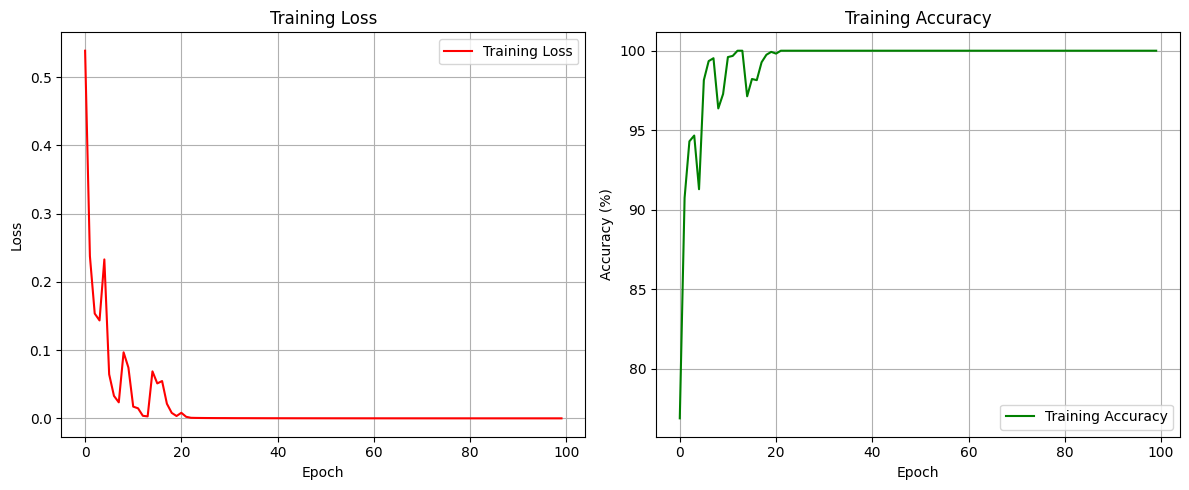

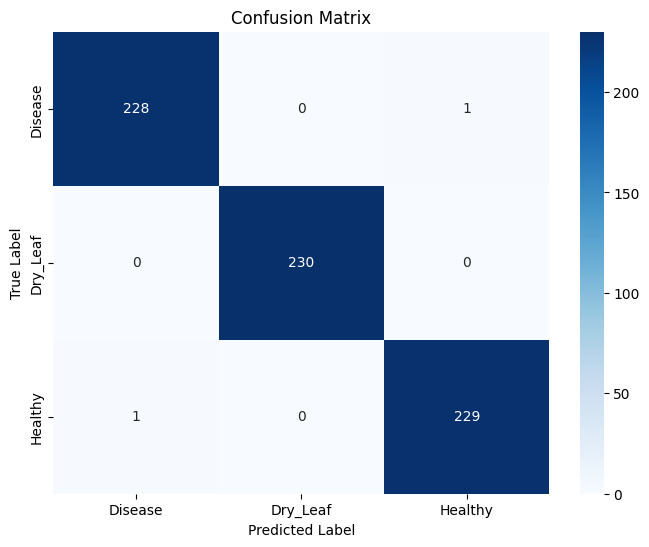

In [26]:
print("\nClassification Report:\n")
print(classification_report(all_true, all_preds, target_names=classes))

# --- Plotting Training History ---
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(loss_history, label='Training Loss', color='red')
plt.title('Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.grid(True)
plt.legend()

plt.subplot(1, 2, 2)
plt.plot([a * 100 for a in acc_history], label='Training Accuracy', color='green')
plt.title('Training Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.grid(True)
plt.legend()

plt.tight_layout()
plt.show()

# --- Plotting Confusion Matrix ---
cm = confusion_matrix(all_true, all_preds)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=classes, yticklabels=classes)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

# Trying different optimizers

Using Stochastic Gradient Descent (SGD)

In [29]:
# 3. QUANTUM CIRCUIT AND HYBRID MODEL DEFINITION

n_qubits = 4
dev = qml.device("default.qubit", wires=n_qubits)

@qml.qnode(dev, interface="torch")
def quantum_circuit(inputs, weights):
    qml.AngleEmbedding(inputs, wires=range(n_qubits))
    for i in range(n_qubits):
        qml.RY(weights[i], wires=i)
    qml.CNOT(wires=[0, 1])
    qml.CNOT(wires=[2, 3])
    qml.CNOT(wires=[1, 2])
    return [qml.expval(qml.PauliZ(i)) for i in range(n_qubits)]

class HybridCNNQNN(nn.Module):
    def __init__(self):
        super(HybridCNNQNN, self).__init__()

        # --- Classical Feature Extractor ---
        self.conv1 = nn.Conv2d(3, 8, kernel_size=3, stride=2, padding=1)
        self.pool1 = nn.MaxPool2d(2)
        self.conv2 = nn.Conv2d(8, 16, kernel_size=3, stride=2, padding=1)
        self.pool2 = nn.MaxPool2d(2)
        self.relu = nn.ReLU()


        dummy_input = torch.randn(1, 3, 128, 128)
        x = self.pool1(self.relu(self.conv1(dummy_input)))
        x = self.pool2(self.relu(self.conv2(x)))
        flattened_size = x.view(x.size(0), -1).size(1)

        # --- Classical-to-Quantum Link ---
        self.fc_link = nn.Linear(flattened_size, 4)

        # --- Quantum Layer ---
        weight_shapes = {"weights": n_qubits}
        self.quantum_layer = qml.qnn.TorchLayer(quantum_circuit, weight_shapes)

        # --- Classical Classifier Head ---
        self.fc_out = nn.Linear(4, 3)

    def forward(self, x):
        x = self.pool1(self.relu(self.conv1(x)))
        x = self.pool2(self.relu(self.conv2(x)))
        x = x.view(x.size(0), -1)
        x = self.fc_link(x)
        x = self.quantum_layer(x)
        return self.fc_out(x)



model = HybridCNNQNN()
optimizer = torch.optim.SGD(model.parameters(), lr=0.01)
loss_fn = nn.CrossEntropyLoss()

from torch.optim.lr_scheduler import StepLR
scheduler = StepLR(optimizer, step_size=30, gamma=0.1)


print(f"Using {n_qubits} qubits.")
print(f"Using {type(optimizer).__name__} optimizer with {optimizer.param_groups[0]['lr']} learning rate")
print("Training setup complete.")

Using 4 qubits.
Using SGD optimizer with 0.01 learning rate
Training setup complete.


In [30]:
import time


EPOCHS = 100
loss_history = []
acc_history = []

print("Starting training...")
start = time.time()



for epoch in range(EPOCHS):
    model.train()
    running_loss = 0.0
    correct_preds = 0
    total_preds = 0

    for batch_X, batch_y in train_loader:
        optimizer.zero_grad()
        y_pred = model(batch_X)
        loss = loss_fn(y_pred, batch_y)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        y_pred_class = torch.argmax(y_pred, dim=1)
        correct_preds += (y_pred_class == batch_y).sum().item()
        total_preds += batch_y.size(0)

    epoch_loss = running_loss / len(train_loader)
    epoch_acc = correct_preds / total_preds
    loss_history.append(epoch_loss)
    acc_history.append(epoch_acc)

    # Step the scheduler after each epoch
    scheduler.step()

    print(f"Epoch {epoch+1}/{EPOCHS} -> Loss: {epoch_loss:.4f}, Accuracy: {epoch_acc*100:.2f}%")

end = time.time()
print(f"Training time: {end - start} seconds")
print("Training finished.")

Starting training...
Epoch 1/100 -> Loss: 1.1196, Accuracy: 33.32%
Epoch 2/100 -> Loss: 1.1020, Accuracy: 33.32%
Epoch 3/100 -> Loss: 1.0621, Accuracy: 33.32%
Epoch 4/100 -> Loss: 0.9213, Accuracy: 63.16%
Epoch 5/100 -> Loss: 0.8043, Accuracy: 66.64%
Epoch 6/100 -> Loss: 0.7225, Accuracy: 66.64%
Epoch 7/100 -> Loss: 0.6557, Accuracy: 66.64%
Epoch 8/100 -> Loss: 0.5952, Accuracy: 66.64%
Epoch 9/100 -> Loss: 0.5633, Accuracy: 66.64%
Epoch 10/100 -> Loss: 0.5451, Accuracy: 66.64%
Epoch 11/100 -> Loss: 0.5301, Accuracy: 65.37%
Epoch 12/100 -> Loss: 0.5203, Accuracy: 66.64%
Epoch 13/100 -> Loss: 0.5106, Accuracy: 67.04%
Epoch 14/100 -> Loss: 0.5068, Accuracy: 66.86%
Epoch 15/100 -> Loss: 0.5043, Accuracy: 66.21%
Epoch 16/100 -> Loss: 0.4981, Accuracy: 67.55%
Epoch 17/100 -> Loss: 0.4971, Accuracy: 68.17%
Epoch 18/100 -> Loss: 0.4898, Accuracy: 67.30%
Epoch 19/100 -> Loss: 0.4897, Accuracy: 67.80%
Epoch 20/100 -> Loss: 0.4876, Accuracy: 67.15%
Epoch 21/100 -> Loss: 0.4858, Accuracy: 69.22%
E

In [31]:
#EVALUATION AND VISUALIZATION

print("Evaluating on test data...")
model.eval()
all_preds = []
all_true = []
with torch.no_grad():
    for batch_X, batch_y in test_loader:
        y_test_pred = model(batch_X)
        predicted_classes = torch.argmax(y_test_pred, dim=1)
        all_preds.extend(predicted_classes.numpy())
        all_true.extend(batch_y.numpy())

print("\nClassification Report:\n")
print(classification_report(all_true, all_preds, target_names=classes))

Evaluating on test data...

Classification Report:

              precision    recall  f1-score   support

     Disease       0.89      0.72      0.79       229
    Dry_Leaf       1.00      1.00      1.00       230
     Healthy       0.76      0.91      0.83       230

    accuracy                           0.88       689
   macro avg       0.88      0.88      0.88       689
weighted avg       0.88      0.88      0.88       689



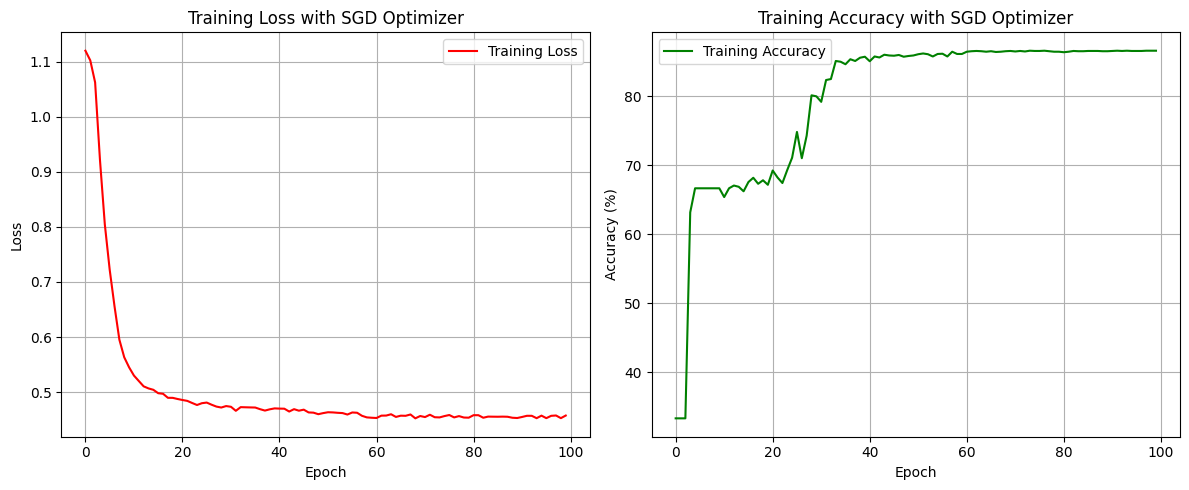

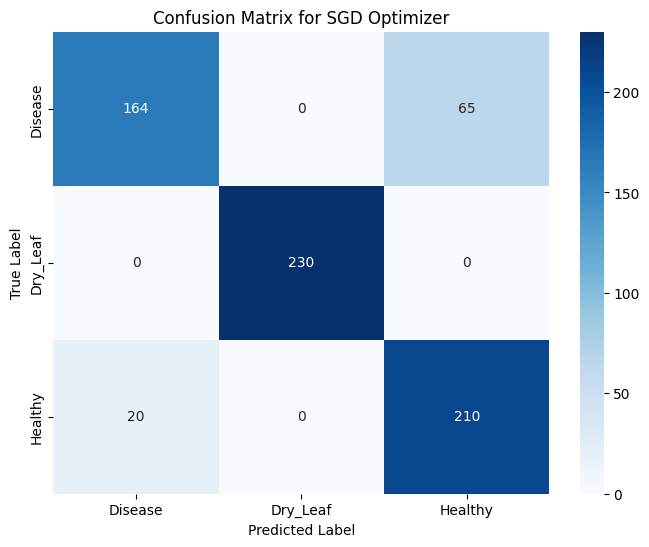

In [34]:
# --- Plotting Training History ---
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(loss_history, label='Training Loss', color='red')
plt.title('Training Loss with SGD Optimizer')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.grid(True)
plt.legend()

plt.subplot(1, 2, 2)
plt.plot([a * 100 for a in acc_history], label='Training Accuracy', color='green')
plt.title('Training Accuracy with SGD Optimizer')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.grid(True)
plt.legend()

plt.tight_layout()
plt.show()


# --- Plotting Confusion Matrix ---
cm = confusion_matrix(all_true, all_preds)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=classes, yticklabels=classes)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix for SGD Optimizer')
plt.show()

Using Root Mean Square Propagation (RMSProp) Optimizer

In [35]:
model = HybridCNNQNN()
optimizer = torch.optim.RMSprop(model.parameters(), lr=0.001)
loss_fn = nn.CrossEntropyLoss()

print(f"Using {n_qubits} qubits.")
print(f"Using {type(optimizer).__name__} optimizer with {optimizer.param_groups[0]['lr']} learning rate")
print("Training setup complete.")

Using 4 qubits.
Using RMSprop optimizer with 0.001 learning rate
Training setup complete.


In [36]:
EPOCHS = 100
loss_history = []
acc_history = []

print("Starting training...")
start = time.time()
for epoch in range(EPOCHS):
    model.train()
    running_loss = 0.0
    correct_preds = 0
    total_preds = 0

    for batch_X, batch_y in train_loader:
        optimizer.zero_grad()
        y_pred = model(batch_X)
        loss = loss_fn(y_pred, batch_y)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        y_pred_class = torch.argmax(y_pred, dim=1)
        correct_preds += (y_pred_class == batch_y).sum().item()
        total_preds += batch_y.size(0)

    epoch_loss = running_loss / len(train_loader)
    epoch_acc = correct_preds / total_preds
    loss_history.append(epoch_loss)
    acc_history.append(epoch_acc)

    print(f"Epoch {epoch+1}/{EPOCHS} -> Loss: {epoch_loss:.4f}, Accuracy: {epoch_acc*100:.2f}%")

end = time.time()
print(f"Training time: {end - start} seconds")
print("Training finished.")

Starting training...
Epoch 1/100 -> Loss: 1.0067, Accuracy: 62.50%
Epoch 2/100 -> Loss: 0.8373, Accuracy: 66.68%
Epoch 3/100 -> Loss: 0.7209, Accuracy: 66.68%
Epoch 4/100 -> Loss: 0.6150, Accuracy: 81.16%
Epoch 5/100 -> Loss: 0.5012, Accuracy: 88.09%
Epoch 6/100 -> Loss: 0.4183, Accuracy: 90.93%
Epoch 7/100 -> Loss: 0.4495, Accuracy: 82.61%
Epoch 8/100 -> Loss: 0.3440, Accuracy: 90.53%
Epoch 9/100 -> Loss: 0.2881, Accuracy: 91.69%
Epoch 10/100 -> Loss: 0.2541, Accuracy: 91.83%
Epoch 11/100 -> Loss: 0.2077, Accuracy: 93.47%
Epoch 12/100 -> Loss: 0.1719, Accuracy: 94.37%
Epoch 13/100 -> Loss: 0.1605, Accuracy: 94.74%
Epoch 14/100 -> Loss: 0.1413, Accuracy: 95.21%
Epoch 15/100 -> Loss: 0.1151, Accuracy: 96.77%
Epoch 16/100 -> Loss: 0.0916, Accuracy: 97.57%
Epoch 17/100 -> Loss: 0.0930, Accuracy: 97.13%
Epoch 18/100 -> Loss: 0.0819, Accuracy: 97.46%
Epoch 19/100 -> Loss: 0.0621, Accuracy: 98.48%
Epoch 20/100 -> Loss: 0.0910, Accuracy: 96.91%
Epoch 21/100 -> Loss: 0.0726, Accuracy: 97.71%
E

In [37]:
#EVALUATION AND VISUALIZATION

print("Evaluating on test data...")
model.eval()
all_preds = []
all_true = []
with torch.no_grad():
    for batch_X, batch_y in test_loader:
        y_test_pred = model(batch_X)
        predicted_classes = torch.argmax(y_test_pred, dim=1)
        all_preds.extend(predicted_classes.numpy())
        all_true.extend(batch_y.numpy())

print("\nClassification Report:\n")
print(classification_report(all_true, all_preds, target_names=classes))

Evaluating on test data...

Classification Report:

              precision    recall  f1-score   support

     Disease       0.99      0.98      0.98       229
    Dry_Leaf       1.00      1.00      1.00       230
     Healthy       0.98      0.99      0.98       230

    accuracy                           0.99       689
   macro avg       0.99      0.99      0.99       689
weighted avg       0.99      0.99      0.99       689



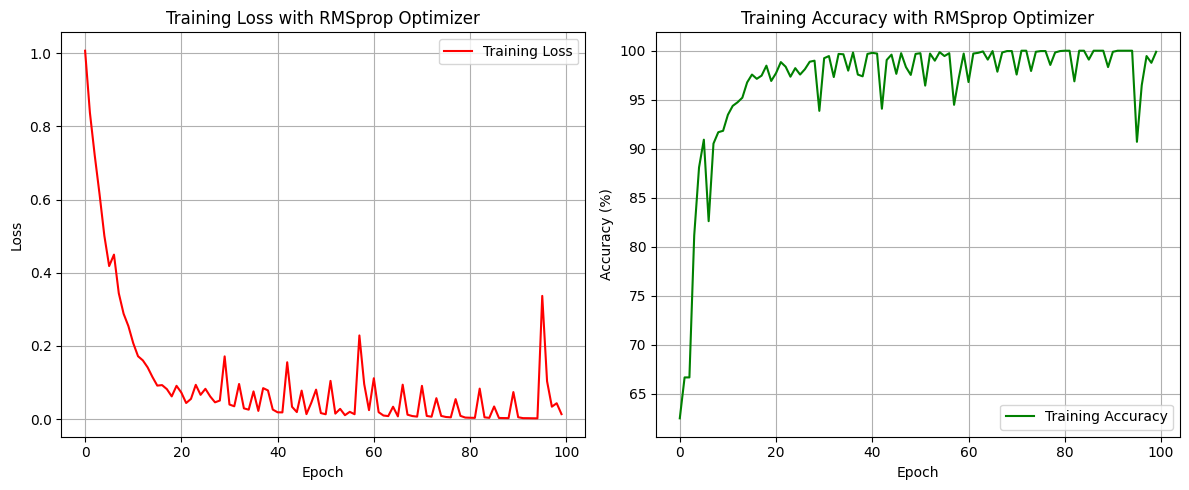

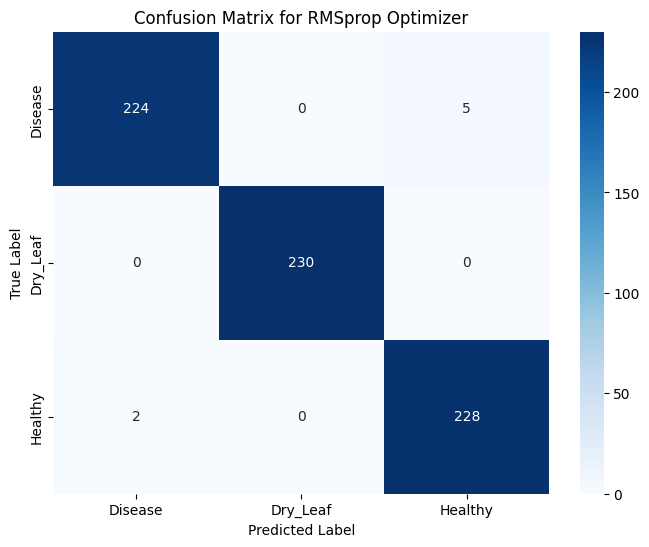

In [38]:
# --- Plotting Training History ---
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(loss_history, label='Training Loss', color='red')
plt.title('Training Loss with RMSprop Optimizer')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.grid(True)
plt.legend()

plt.subplot(1, 2, 2)
plt.plot([a * 100 for a in acc_history], label='Training Accuracy', color='green')
plt.title('Training Accuracy with RMSprop Optimizer')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.grid(True)
plt.legend()

plt.tight_layout()
plt.show()


# --- Plotting Confusion Matrix ---
cm = confusion_matrix(all_true, all_preds)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=classes, yticklabels=classes)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix for RMSprop Optimizer')
plt.show()

Using Nesterov Adaptive Moment Estimation (Nadam) optimizer

In [39]:
model = HybridCNNQNN()
optimizer = torch.optim.NAdam(model.parameters(), lr=0.001)
loss_fn = nn.CrossEntropyLoss()

print(f"Using {n_qubits} qubits.")
print(f"Using {type(optimizer).__name__} optimizer with {optimizer.param_groups[0]['lr']} learning rate")
print("Training setup complete.")

Using 4 qubits.
Using NAdam optimizer with 0.001 learning rate
Training setup complete.


In [40]:
EPOCHS = 100
loss_history = []
acc_history = []

print("Starting training...")
start = time.time()
for epoch in range(EPOCHS):
    model.train()
    running_loss = 0.0
    correct_preds = 0
    total_preds = 0

    for batch_X, batch_y in train_loader:
        optimizer.zero_grad()
        y_pred = model(batch_X)
        loss = loss_fn(y_pred, batch_y)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        y_pred_class = torch.argmax(y_pred, dim=1)
        correct_preds += (y_pred_class == batch_y).sum().item()
        total_preds += batch_y.size(0)

    epoch_loss = running_loss / len(train_loader)
    epoch_acc = correct_preds / total_preds
    loss_history.append(epoch_loss)
    acc_history.append(epoch_acc)

    print(f"Epoch {epoch+1}/{EPOCHS} -> Loss: {epoch_loss:.4f}, Accuracy: {epoch_acc*100:.2f}%")

end = time.time()
print(f"Training time: {end - start} seconds")
print("Training finished.")

Starting training...
Epoch 1/100 -> Loss: 0.9692, Accuracy: 59.17%
Epoch 2/100 -> Loss: 0.7958, Accuracy: 66.75%
Epoch 3/100 -> Loss: 0.6822, Accuracy: 74.01%
Epoch 4/100 -> Loss: 0.5955, Accuracy: 82.43%
Epoch 5/100 -> Loss: 0.5203, Accuracy: 86.57%
Epoch 6/100 -> Loss: 0.4401, Accuracy: 89.47%
Epoch 7/100 -> Loss: 0.3840, Accuracy: 90.38%
Epoch 8/100 -> Loss: 0.3309, Accuracy: 91.83%
Epoch 9/100 -> Loss: 0.2901, Accuracy: 92.70%
Epoch 10/100 -> Loss: 0.2541, Accuracy: 93.90%
Epoch 11/100 -> Loss: 0.2225, Accuracy: 95.25%
Epoch 12/100 -> Loss: 0.1883, Accuracy: 96.84%
Epoch 13/100 -> Loss: 0.1668, Accuracy: 97.31%
Epoch 14/100 -> Loss: 0.1438, Accuracy: 97.97%
Epoch 15/100 -> Loss: 0.1311, Accuracy: 98.08%
Epoch 16/100 -> Loss: 0.1601, Accuracy: 96.44%
Epoch 17/100 -> Loss: 0.1026, Accuracy: 98.84%
Epoch 18/100 -> Loss: 0.0914, Accuracy: 99.27%
Epoch 19/100 -> Loss: 0.0825, Accuracy: 99.20%
Epoch 20/100 -> Loss: 0.0742, Accuracy: 99.49%
Epoch 21/100 -> Loss: 0.0667, Accuracy: 99.53%
E

In [41]:
#EVALUATION AND VISUALIZATION

print("Evaluating on test data...")
model.eval()
all_preds = []
all_true = []
with torch.no_grad():
    for batch_X, batch_y in test_loader:
        y_test_pred = model(batch_X)
        predicted_classes = torch.argmax(y_test_pred, dim=1)
        all_preds.extend(predicted_classes.numpy())
        all_true.extend(batch_y.numpy())

print("\nClassification Report:\n")
print(classification_report(all_true, all_preds, target_names=classes))

Evaluating on test data...

Classification Report:

              precision    recall  f1-score   support

     Disease       1.00      0.99      0.99       229
    Dry_Leaf       1.00      1.00      1.00       230
     Healthy       0.99      1.00      0.99       230

    accuracy                           0.99       689
   macro avg       0.99      0.99      0.99       689
weighted avg       0.99      0.99      0.99       689



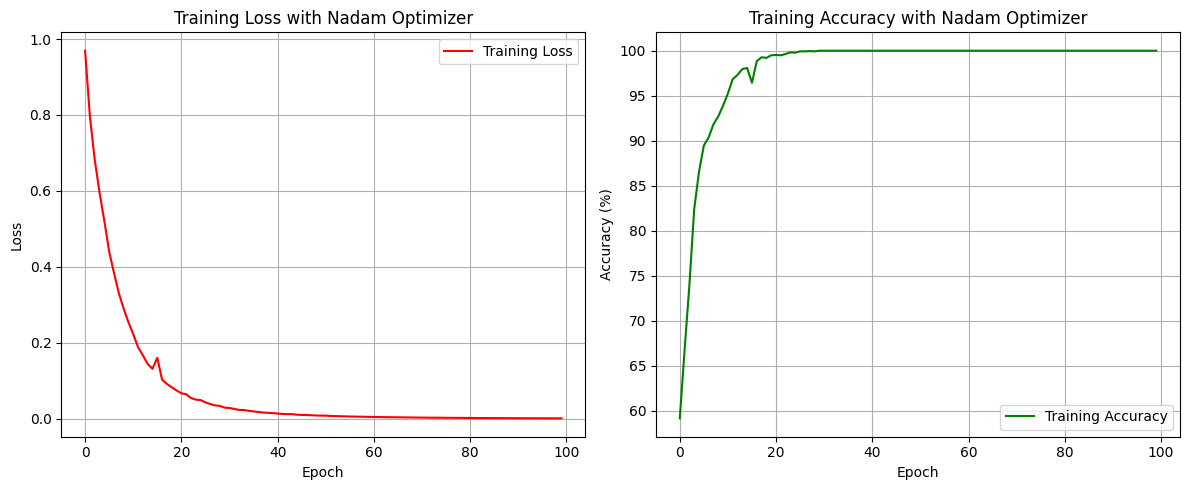

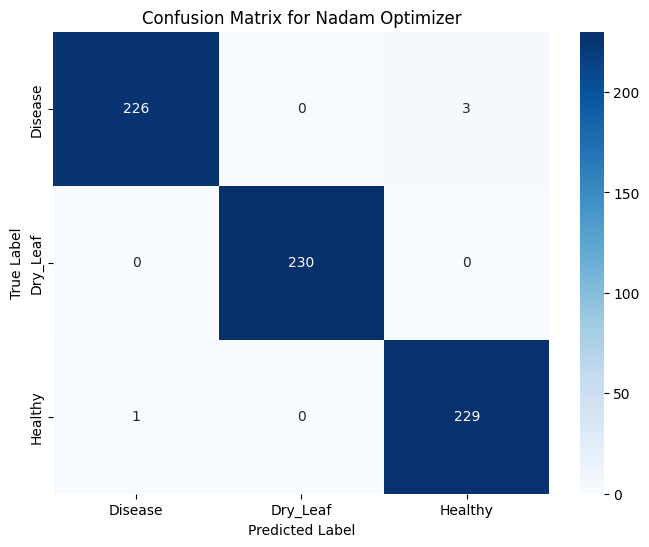

In [42]:
# --- Plotting Training History ---
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(loss_history, label='Training Loss', color='red')
plt.title('Training Loss with Nadam Optimizer')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.grid(True)
plt.legend()

plt.subplot(1, 2, 2)
plt.plot([a * 100 for a in acc_history], label='Training Accuracy', color='green')
plt.title('Training Accuracy with Nadam Optimizer')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.grid(True)
plt.legend()

plt.tight_layout()
plt.show()


# --- Plotting Confusion Matrix ---
cm = confusion_matrix(all_true, all_preds)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=classes, yticklabels=classes)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix for Nadam Optimizer')
plt.show()